#### Download the data

In [1]:
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet

--2024-05-18 10:09:46--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 99.84.245.193, 99.84.245.9, 99.84.245.141, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|99.84.245.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47673370 (45M) [application/x-www-form-urlencoded]
Saving to: ‘yellow_tripdata_2023-01.parquet.1’

yellow_tripdata_202 100%[===================>]  45.46M  25.9MB/s    in 1.8s    

2024-05-18 10:09:48 (25.9 MB/s) - ‘yellow_tripdata_2023-01.parquet.1’ saved [47673370/47673370]

--2024-05-18 10:09:49--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 99.84.245.193, 99.84.245.9, 99.84.245.141, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|99.84.245.193|:443... connect

#### Read data

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
sklearn.set_config()
pd.set_option("display.max_columns", 500)

In [3]:
# Read January data
df = pd.read_parquet("yellow_tripdata_2023-01.parquet")
print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")
df.head()

Rows: 3,066,766, Columns: 19


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [4]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

#### Duration

In [5]:
# Calculate duration
df["duration"] = df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
df["duration"] = df["duration"].dt.total_seconds() / 60

In [6]:
# Standard deviation
print(df["duration"].std())

42.59435124195458


#### Dropping outliers

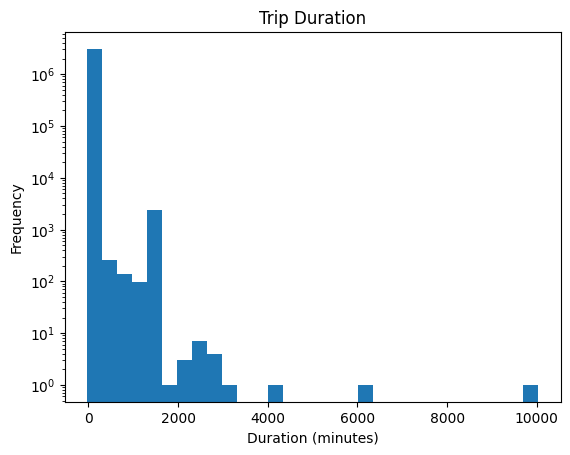

In [7]:
df["duration"].plot(kind="hist", bins=30, logy=True)
plt.title("Trip Duration")
plt.xlabel("Duration (minutes)")
plt.show()

In [21]:
df = df[(df["duration"] >= 1) & (df["duration"] <= 60)]
print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")

Rows: 3,009,173, Columns: 20


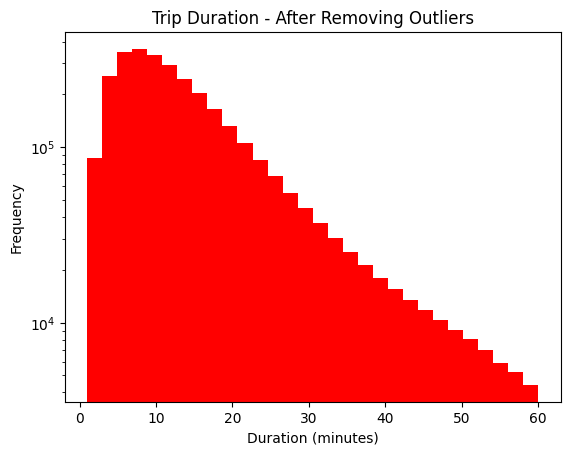

In [22]:
df["duration"].plot(kind="hist", bins=30, logy=True, color="red")
plt.title("Trip Duration - After Removing Outliers")
plt.xlabel("Duration (minutes)")
plt.show()

In [23]:
# fraction of the records left after dropping the outliers
3_009_173/ 3_066_766

0.9812202822125979

#### One-hot encoding

In [24]:
# Convert to list of dictionaries
X = df[["PULocationID", "DOLocationID"]].astype(dtype="str").to_dict(orient="records")
y = df["duration"]

In [25]:
# Initialize DictVectorizer
vectorizer = DictVectorizer()

# Fit and transform the data
X = vectorizer.fit_transform(X)

In [27]:
print(f"Rows: {X.shape[0]:,}, Columns: {X.shape[1]}")

Rows: 3,009,173, Columns: 515


#### Train model

In [28]:
# fit model
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [29]:
# get predictions
preds = lr.predict(X)

In [34]:
# RMSE
root_mean_squared_error(y, preds)

7.6492618170231745

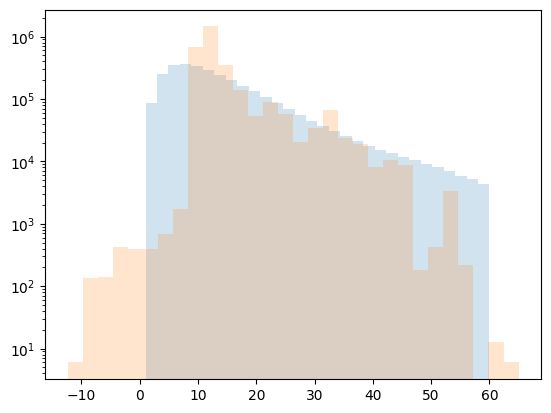

In [43]:
plt.hist(y, bins=30, alpha=0.2, label="Actual", log=True)
plt.hist(preds, bins=30, alpha=0.2, label="Predicted", log=True)
plt.show()

#### Validation

In [45]:
validation = pd.read_parquet("yellow_tripdata_2023-02.parquet",
    columns=["PULocationID", "DOLocationID", "tpep_pickup_datetime", "tpep_dropoff_datetime"]
)
print(f"Rows: {validation.shape[0]:,}, Columns: {validation.shape[1]}")
validation.head()

Rows: 2,913,955, Columns: 4


,PULocationID,DOLocationID,tpep_pickup_datetime,tpep_dropoff_datetime
0,142,163,2023-02-01 00:32:53,2023-02-01 00:34:34
1,71,71,2023-02-01 00:35:16,2023-02-01 00:35:30
2,71,71,2023-02-01 00:35:16,2023-02-01 00:35:30
3,132,26,2023-02-01 00:29:33,2023-02-01 01:01:38
4,161,145,2023-02-01 00:12:28,2023-02-01 00:25:46


In [46]:
# Calculate duration
validation["duration"] = validation["tpep_dropoff_datetime"] - validation["tpep_pickup_datetime"]
validation["duration"] = validation["duration"].dt.total_seconds() / 60

In [52]:
# Filter out outliers
validation = validation[(validation["duration"] >= 1) & (validation["duration"] <= 60)]

In [53]:
# Prepare Xs and ys
X_val, y_val = validation[["PULocationID", "DOLocationID"]].astype(dtype="str").to_dict(orient="records"), validation["duration"]

In [54]:
# Transform Xs
X_val = vectorizer.transform(X_val)

In [55]:
# Get predictions
val_preds = lr.predict(X_val)

In [56]:
# RMSE val
root_mean_squared_error(y_val, val_preds)

7.811820944560843

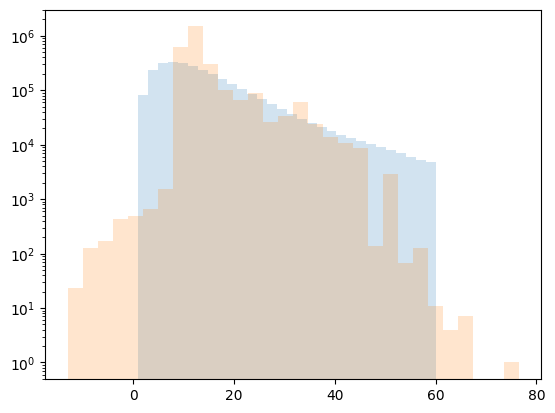

In [57]:
plt.hist(y_val, bins=30, alpha=0.2, label="Actual", log=True)
plt.hist(val_preds, bins=30, alpha=0.2, label="Predicted", log=True)
plt.show()